# Modeling fastText + Centroid Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold
)
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestCentroid
from joblib import dump

root_path = Path.cwd().parents[1]
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold,
    plot_skorch_history
)
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data_cv
)

from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector
from src.fasttext_vectorizer import FastTextVectorizer

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Repro Setup --- we try to make everything reproducible
import os, random, numpy as np, torch
SEED = 42  #global seed

random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision('high')

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)

**a) Centroid with basic preprocessed data**

In [3]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

In [4]:
#debug
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" 

basic train 
**Note: Important exception as we don´t have any real hyperparameters to tune with basic preprocessed data, we don´t perform our 2-step tpe and grid search and fit the model only once**


Optimizing threshold with nested cross-validation (coarse-to-fine)...
Optimized threshold: -0.100
CV F2-score with optimized threshold: 0.646

Generating unbiased threshold visualization...


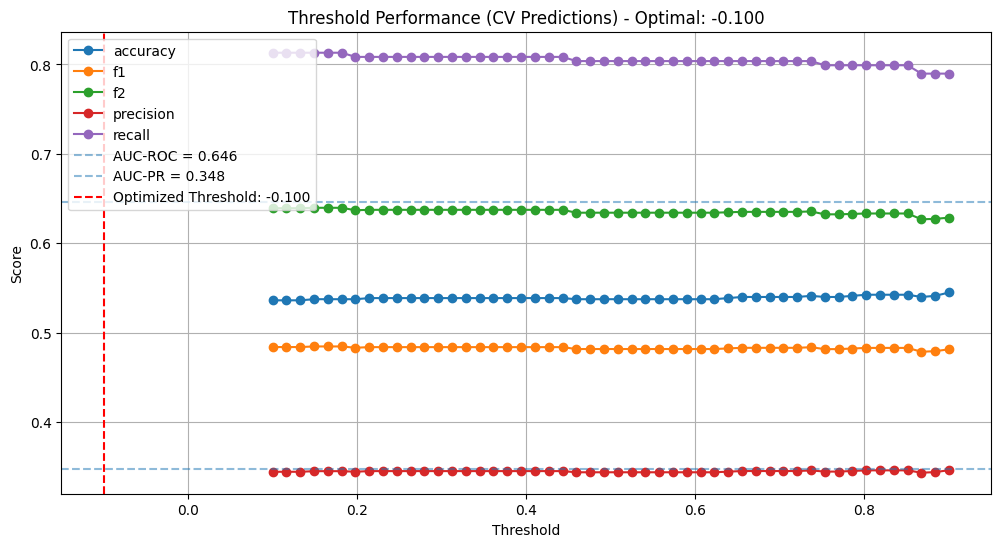

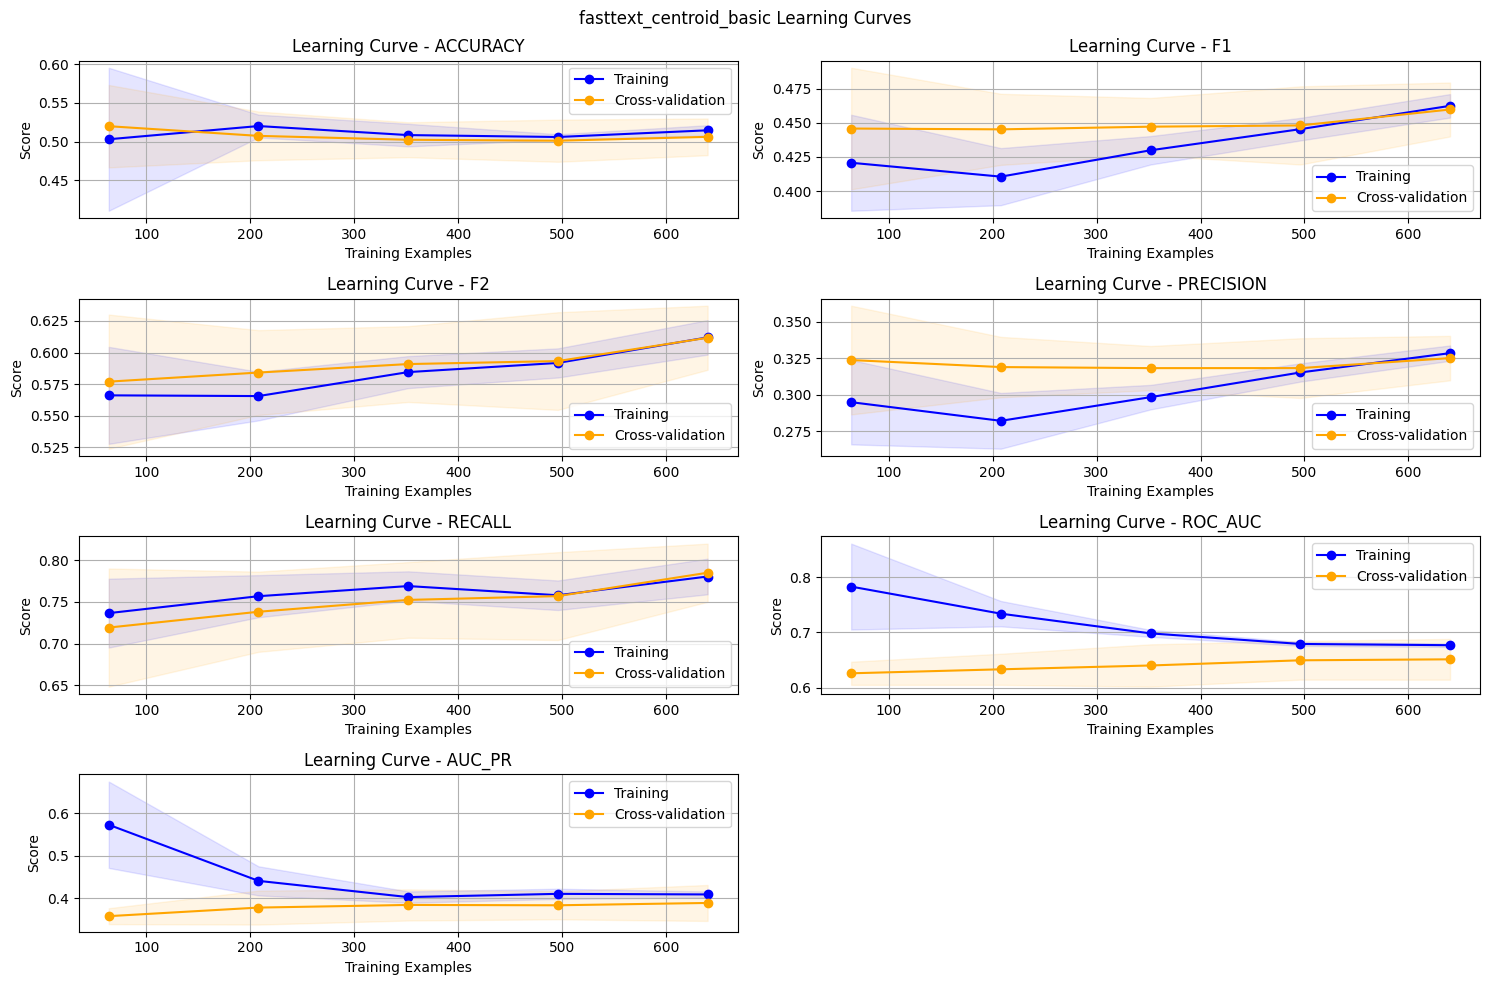


Final Threshold: -0.10
F2-score with default threshold (0.0): 0.569

Test Set Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       146
           1       0.27      1.00      0.43        54

    accuracy                           0.27       200
   macro avg       0.14      0.50      0.21       200
weighted avg       0.07      0.27      0.11       200

Additional Metrics:
Accuracy   0.270
F2-score   0.649
AUC-ROC    0.571
AUC-PR     0.337



c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


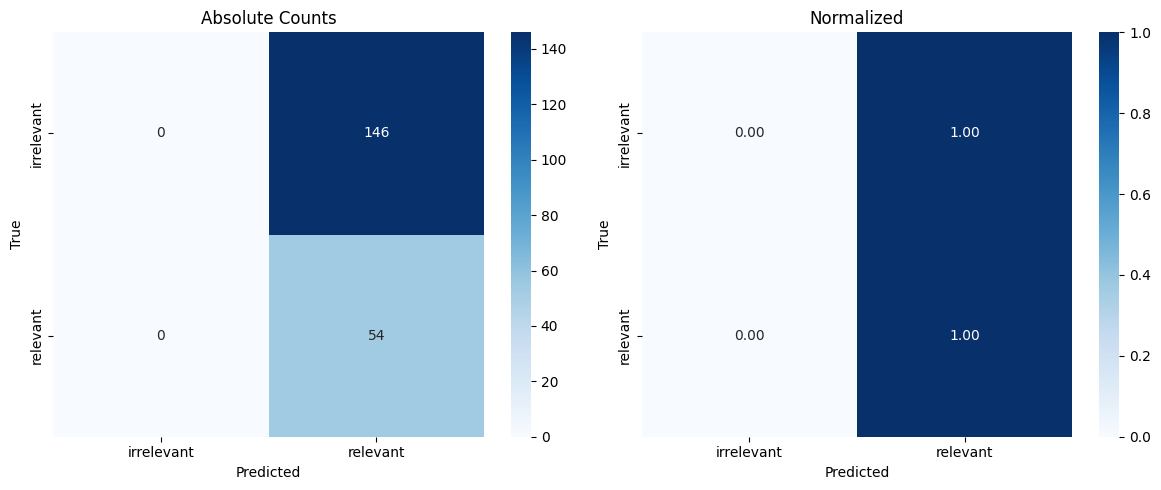

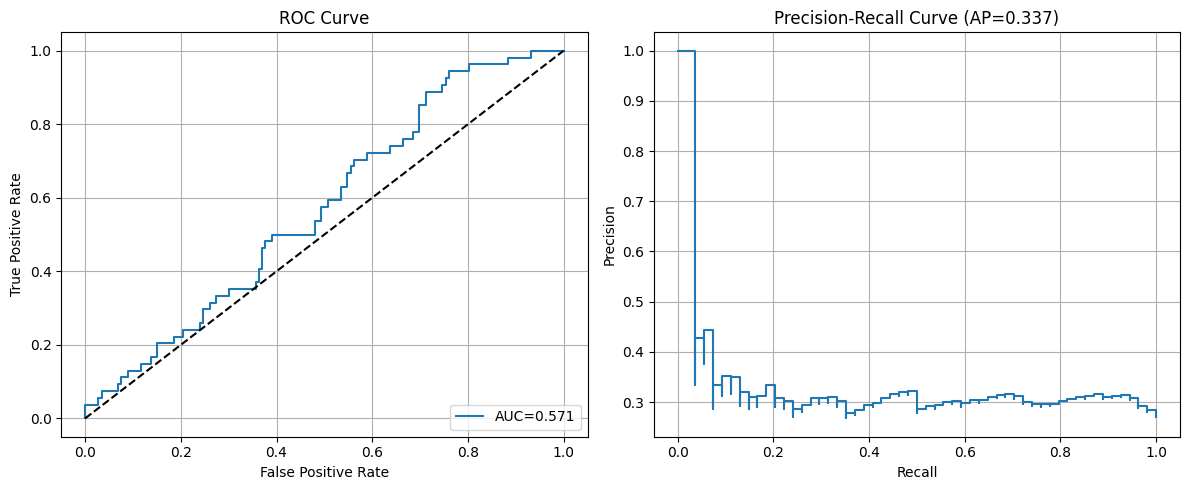

c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Model saved as model_fasttext_centroid_basic.joblib


In [5]:
#perform train-test split
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: PhraseDetector, FastText pooling, Normalizer, NearestCentroid
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")
pipeline_centroid = Pipeline([
    ("embed", FastTextVectorizer(
        lang='de',
        model_dir=f'{root_path}/src/fasttext_embeddings',
        cache_key=ft_bin,
        mode='pool',
        pool='tfidf',
        debug=False
    )),
    ("norm", Normalizer(norm='l2')),
    ("clf", NearestCentroid(metric='euclidean'))
])

# CV Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit model directly (no HPO, as we don´t have real hp to tune)
pipeline_centroid.fit(X_dev, y_dev)
base_model = pipeline_centroid
model_name = "fasttext_centroid_basic"

# Threshold optimization with nested CV
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)
print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Threshold visualization
print("\nGenerating unbiased threshold visualization...")
viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv
)
plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set
y_test_pred = tuned_model.predict(X_test)
y_test_proba = tuned_model.decision_function(X_test)

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.0): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Metrics
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev)
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Summary
results_summary = {
    'model_name': model_name,
    'preprocessing_type': 'basic',
    'optimization_method': 'No HPO + TunedThresholdClassifierCV',
    'best_params': None,
    'cv_results': {
        'best_f2_score': threshold_results['cv_score'],
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_performance_metrics': cv_metrics
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'],
        'test_performance_metrics': test_metrics,
        'formatted_report': test_report_str
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save model
dump({
    'model': tuned_model,
    'base_model': base_model,
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': None,
    'search_type': 'No HPO + TunedThresholdClassifierCV',
    'results_summary': results_summary
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

**b) Centroid based on advanced preprocessed data**

In [3]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

TPE advanced preprocessed data (we only tune our phraser parameters with Optuna)

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'phrases__enable': True, 'phrases__min_count': 68, 'phrases__threshold': 4.136538760776037}
Best F2 score during optimization: 0.643

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


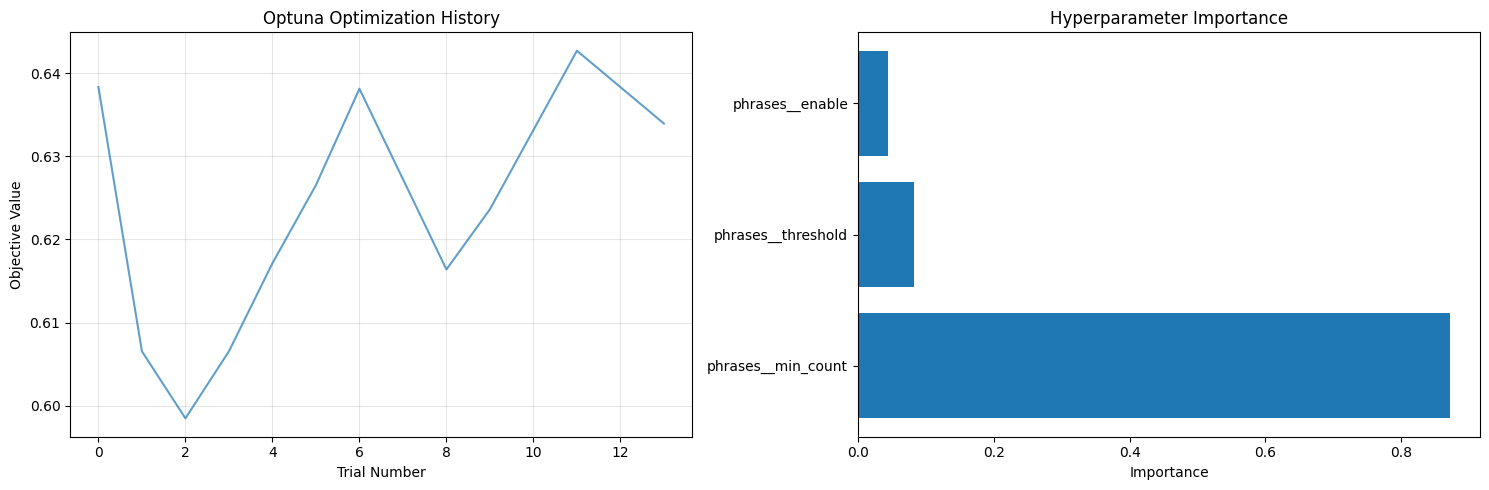


2. Parameter Value Distributions:


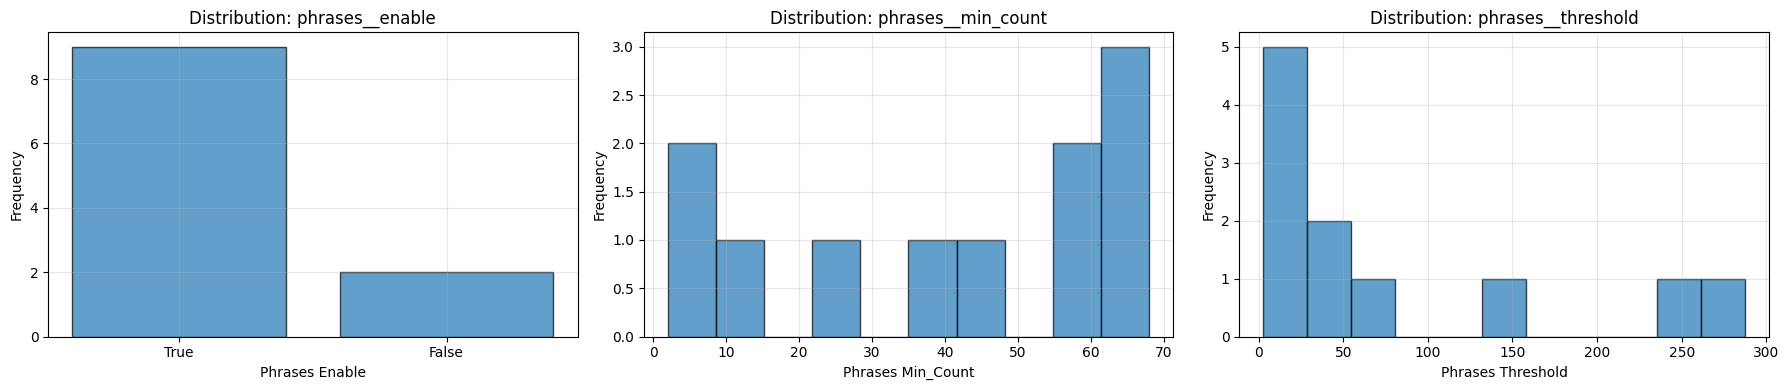


3. Performance vs Individual Parameters:


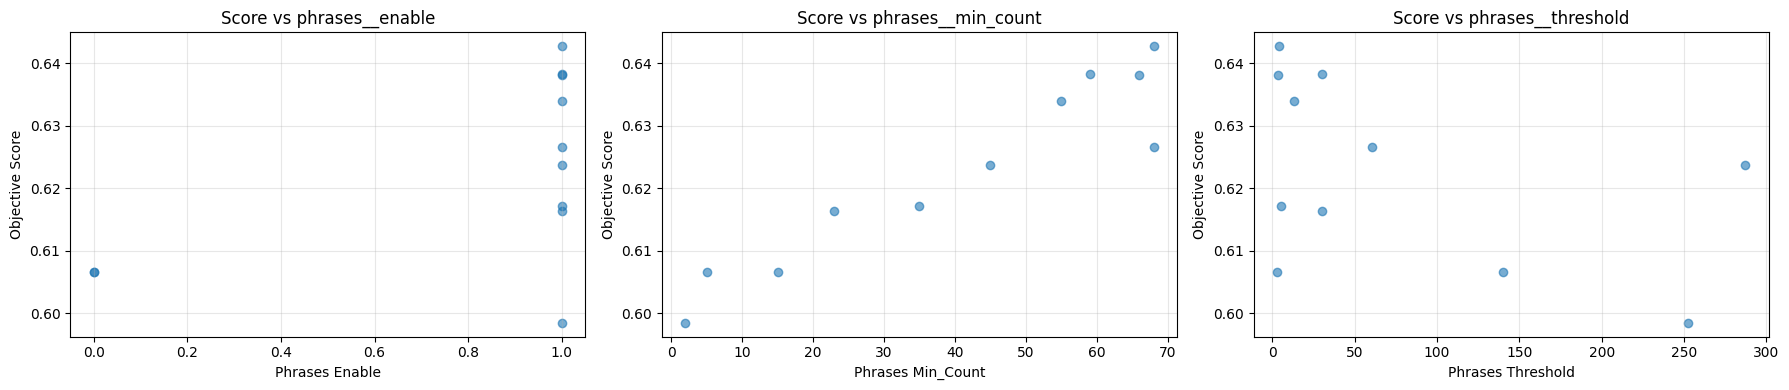


4. Convergence Analysis:


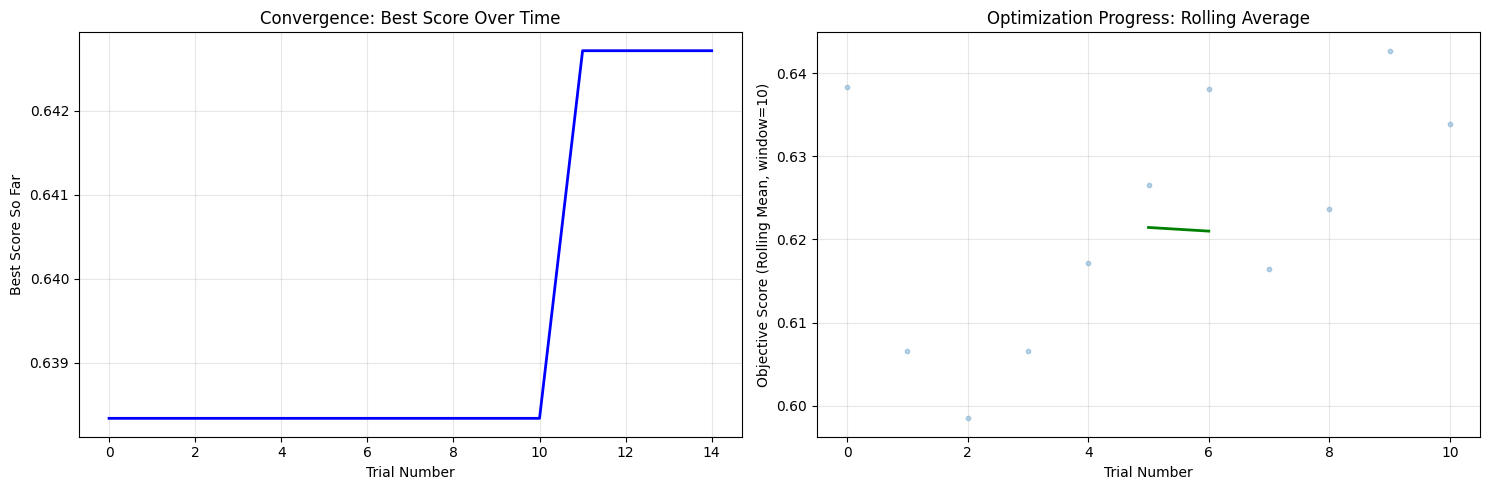


5. Trial Status Overview:


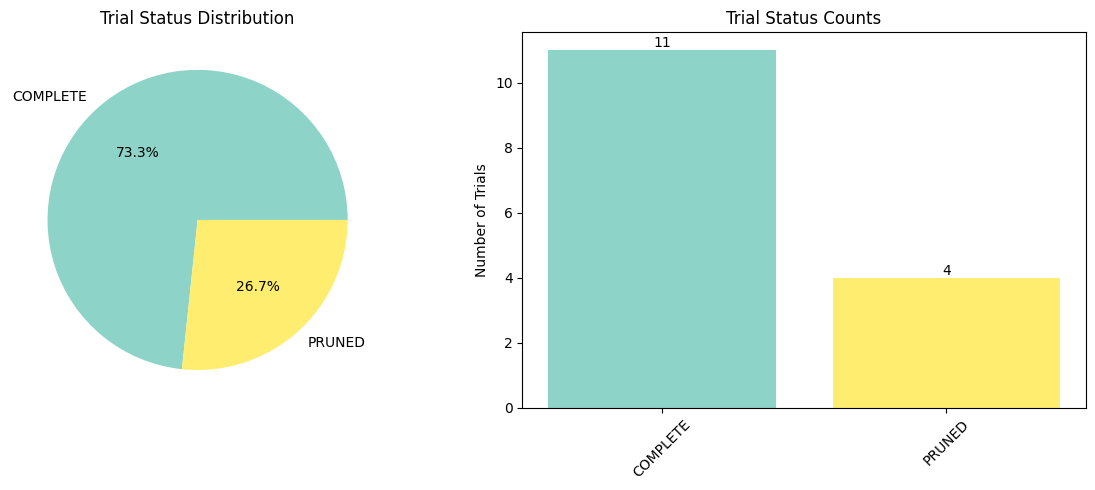


6. Top 10 Best Trials:
Rank Trial#  Score      enable       min_count    threshold   
--------------------------------------------------------------
1    11      0.6427     True         68           4.1365      
2    0       0.6383     True         59           30.4053     
3    6       0.6381     True         66           3.6569      
4    13      0.6339     True         55           12.9915     
5    5       0.6265     True         68           60.7605     
6    9       0.6236     True         45           287.2120    
7    4       0.6171     True         35           5.2651      
8    8       0.6164     True         23           30.3661     
9    1       0.6065     False        5            139.8374    
10   3       0.6065     False        15           2.8465      

7. Study Statistics Summary:
• Total trials: 15
• Successful trials: 11
• Failed trials: 0
• Success rate: 73.3%
• Best trial: #11
• Best objective value: 0.6427
• Score statistics:
  - Mean: 0.6104
  - Std:  0.0235
  -

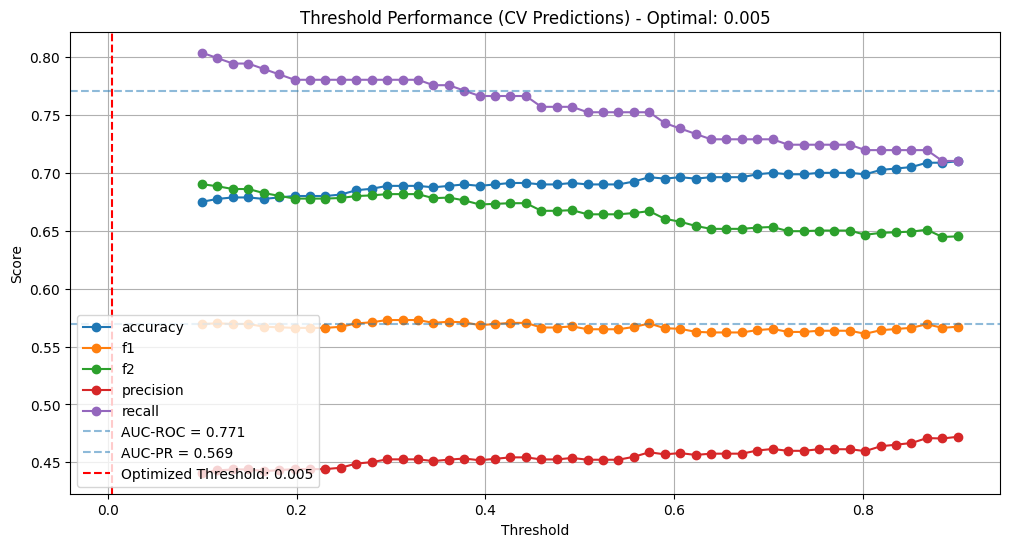

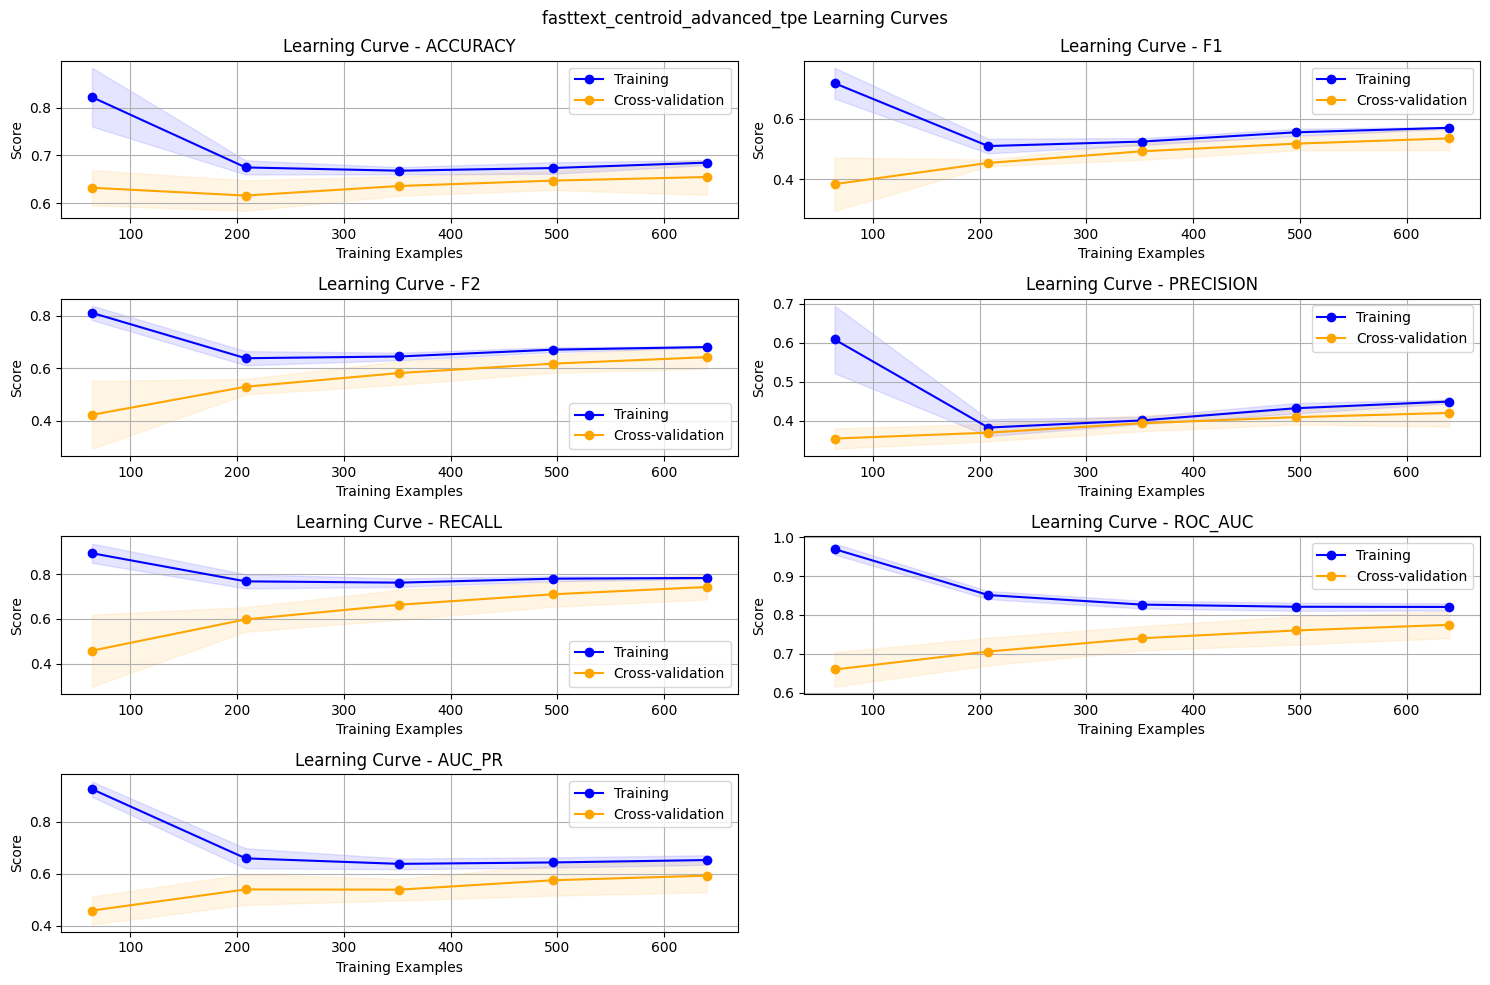


Final Threshold: 0.01
F2-score with default threshold (0.0): 0.602

Test Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.48      0.62       146
           1       0.36      0.80      0.50        54

    accuracy                           0.56       200
   macro avg       0.61      0.64      0.56       200
weighted avg       0.73      0.56      0.58       200

Additional Metrics:
Accuracy   0.565
F2-score   0.642
AUC-ROC    0.746
AUC-PR     0.600



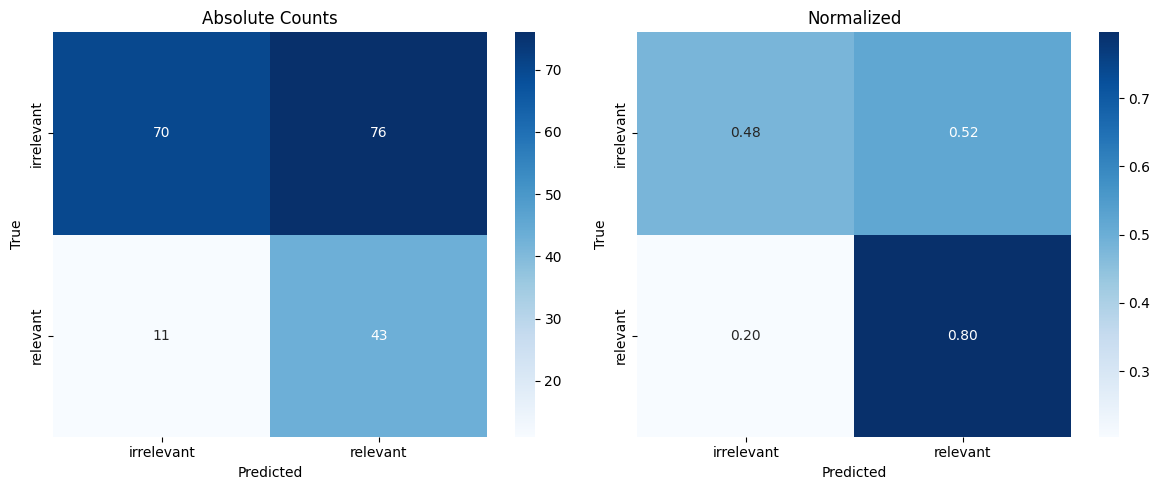

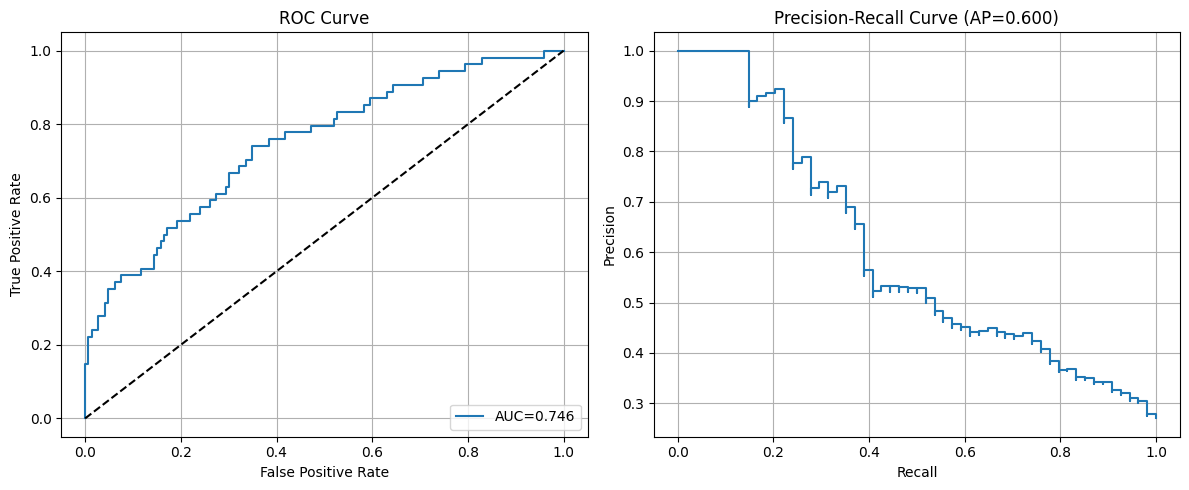


Model saved as model_fasttext_centroid_advanced_tpe.joblib


In [5]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

#for caching
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")

pipeline_bilstm = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("embed", FastTextVectorizer(
        lang='de',
        model_dir=f'{root_path}/src/fasttext_embeddings',
        cache_key=ft_bin,
        mode='pool',
        pool='tfidf',
        debug=False
    )),
    ("norm", Normalizer(norm='l2')),
    ("clf", NearestCentroid(metric='euclidean'))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    # 3 Parameters enabled in our advanced (multi word grouping) pipeline.
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [False, True]),        
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 1, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 300.0, log=True)
}

model_name = "fasttext_centroid_advanced_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_bilstm,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "centroid",
    n_trials=15,  # Intelligent search with early stopping
    n_startup_trials=5, # less aggressive prunning
    n_warmup_steps=1,  # first folds not pruned
    intervall_steps=1, # prunning possible for every fold
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=25,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set
y_test_pred = tuned_model.predict(X_test)
y_test_proba = tuned_model.decision_function(X_test)

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.0): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Metrics
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev)
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)


# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



GridSearch on advanced preprocessed data

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'phrases__enable': True, 'phrases__min_count': 70, 'phrases__threshold': 3.6}
Best F2 score during optimization: 0.643

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


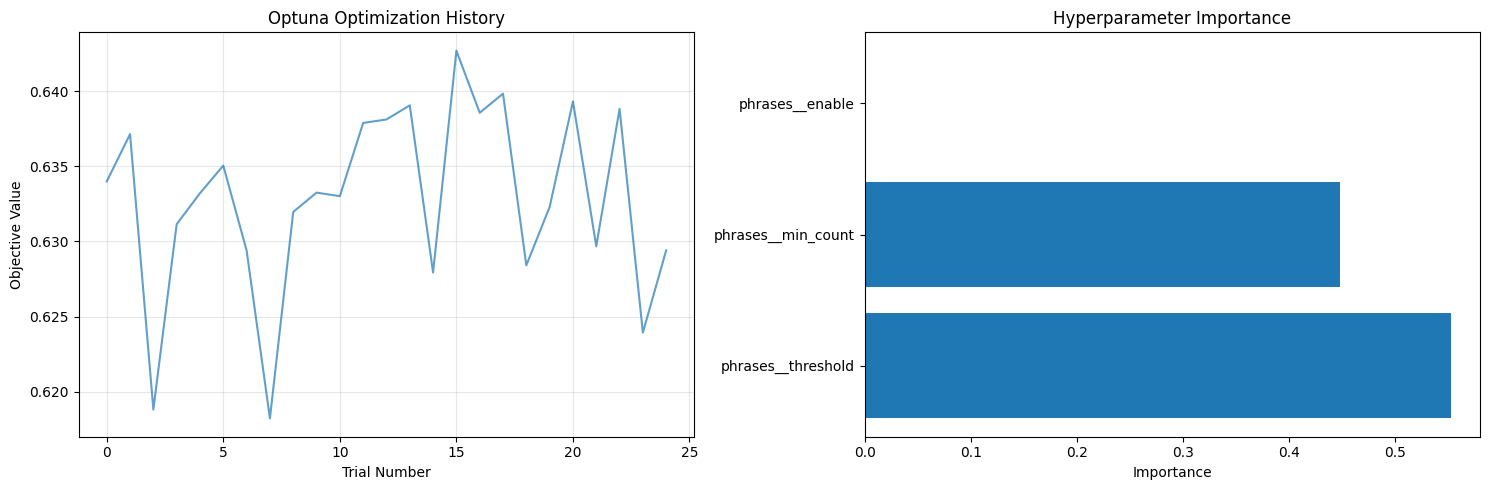


2. Parameter Value Distributions:


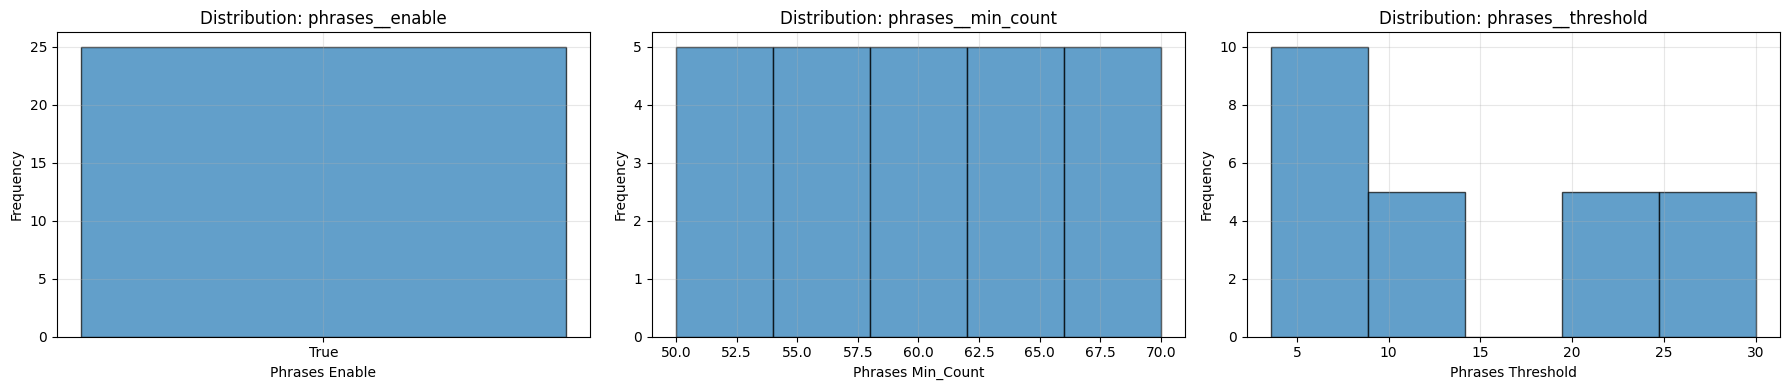


3. Performance vs Individual Parameters:


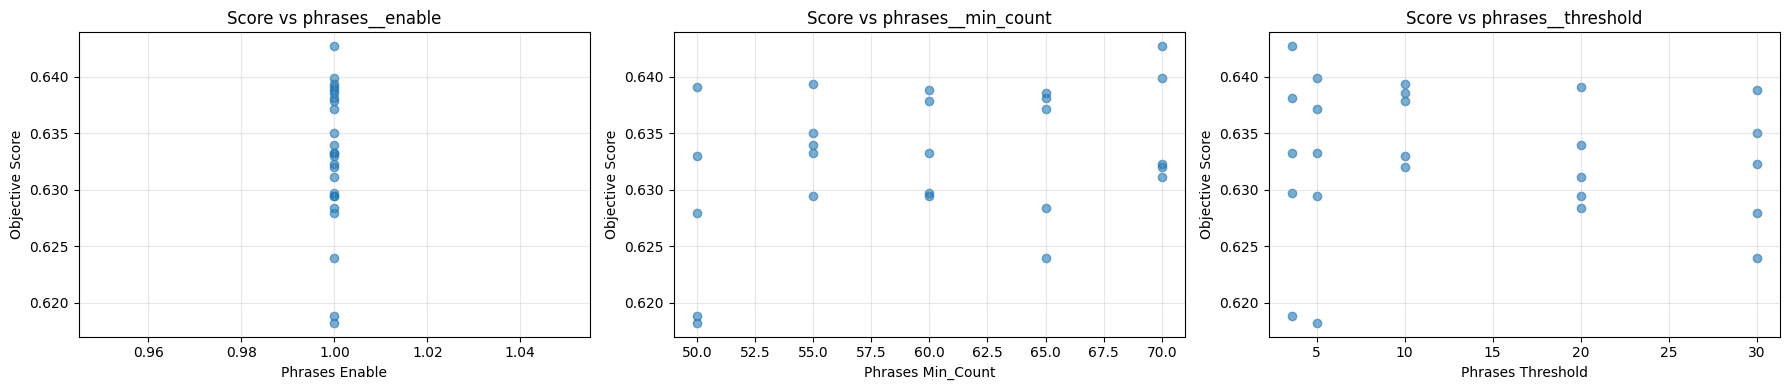


4. Convergence Analysis:


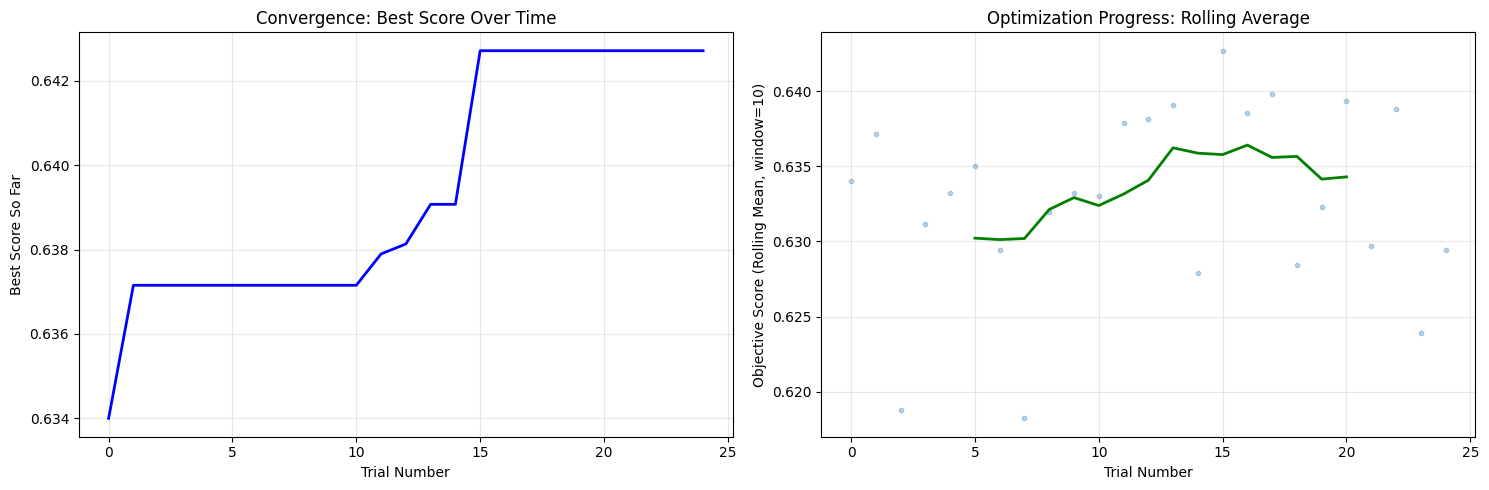


5. Trial Status Overview:


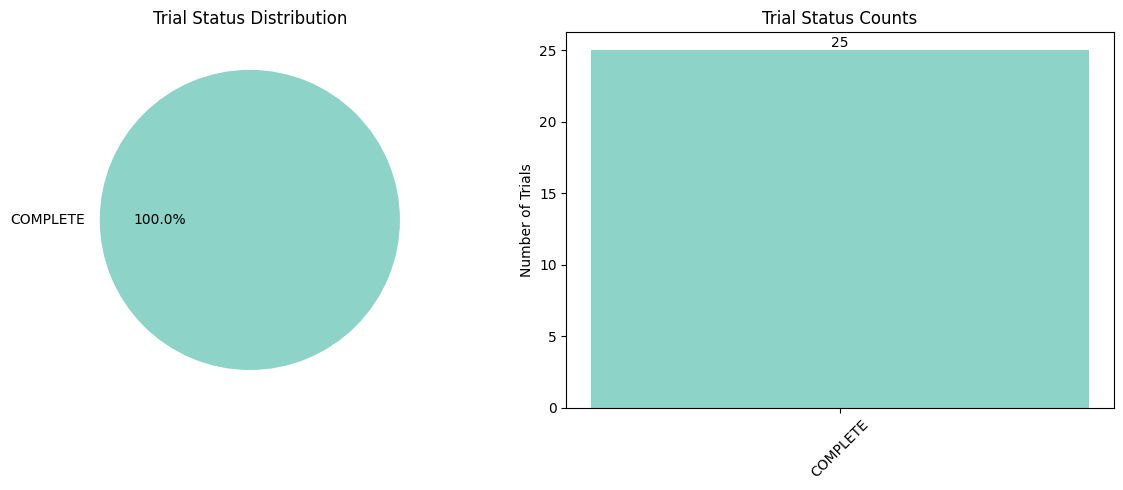


6. Top 10 Best Trials:
Rank Trial#  Score      enable       min_count    threshold   
--------------------------------------------------------------
1    15      0.6427     True         70           3.6000      
2    17      0.6399     True         70           5.0000      
3    20      0.6393     True         55           10.0000     
4    13      0.6391     True         50           20.0000     
5    22      0.6388     True         60           30.0000     
6    16      0.6386     True         65           10.0000     
7    12      0.6381     True         65           3.6000      
8    11      0.6379     True         60           10.0000     
9    1       0.6372     True         65           5.0000      
10   5       0.6351     True         55           30.0000     

7. Study Statistics Summary:
• Total trials: 25
• Successful trials: 25
• Failed trials: 0
• Success rate: 100.0%
• Best trial: #15
• Best objective value: 0.6427
• Score statistics:
  - Mean: 0.6329
  - Std:  0.0062
  

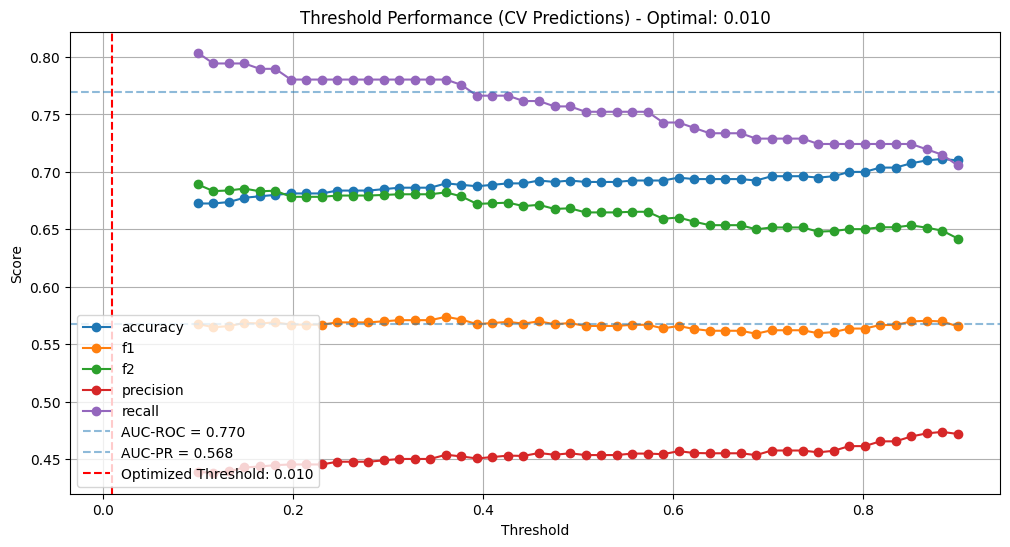

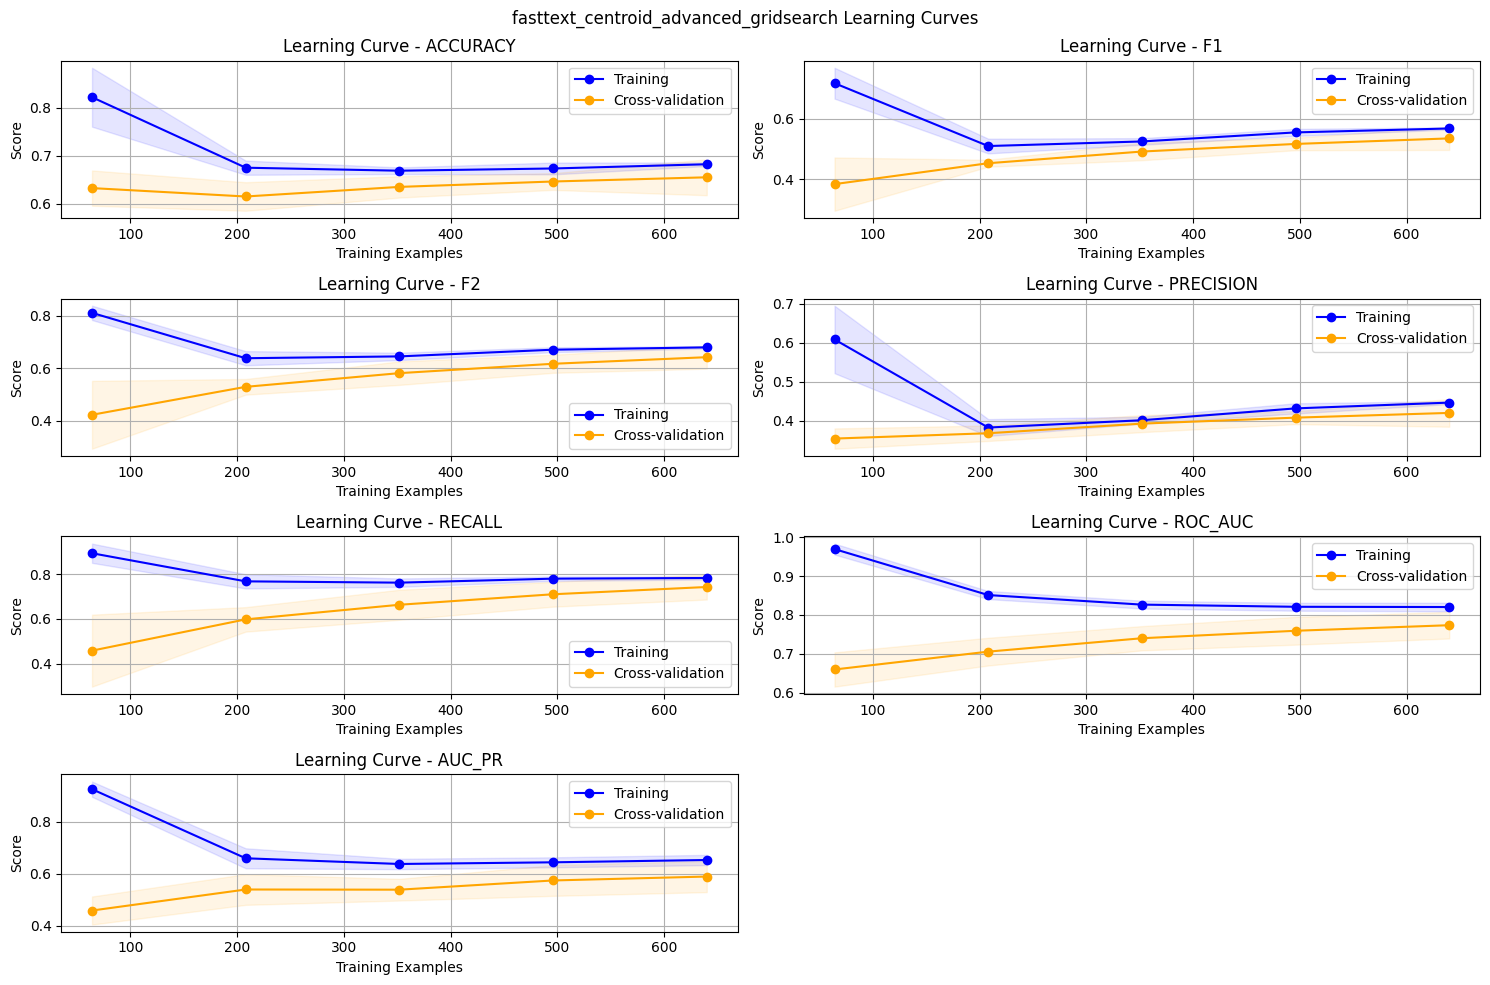


Final Threshold: 0.01
F2-score with default threshold (0.0): 0.598

Test Set Performance:
              precision    recall  f1-score   support

           0       0.87      0.51      0.65       146
           1       0.38      0.80      0.51        54

    accuracy                           0.59       200
   macro avg       0.62      0.65      0.58       200
weighted avg       0.74      0.59      0.61       200

Additional Metrics:
Accuracy   0.590
F2-score   0.652
AUC-ROC    0.742
AUC-PR     0.600



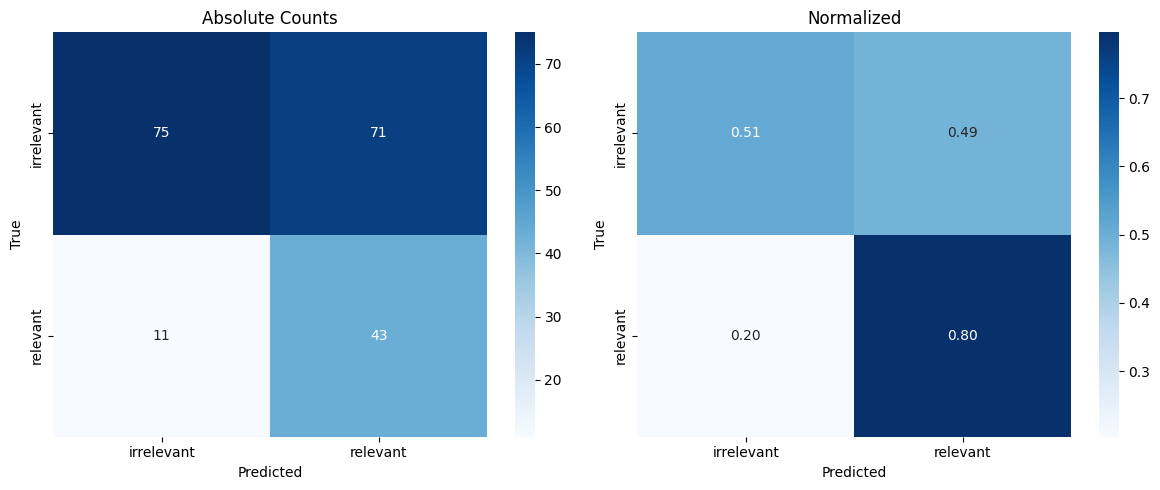

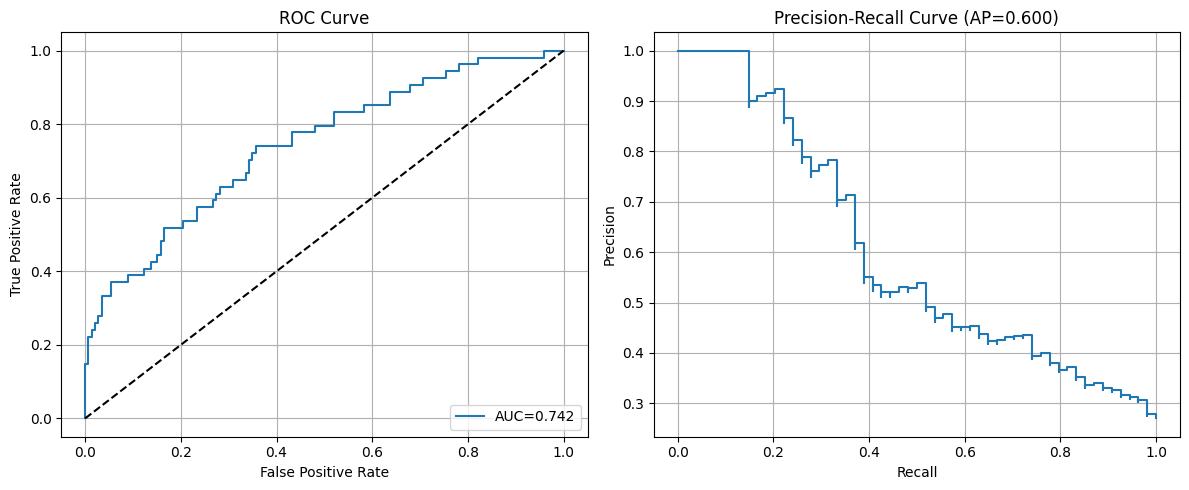


Model saved as model_fasttext_centroid_advanced_gridsearch.joblib


In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

#for caching
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")

pipeline_bilstm = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("embed", FastTextVectorizer(
        lang='de',
        model_dir=f'{root_path}/src/fasttext_embeddings',
        cache_key=ft_bin,
        mode='pool',
        pool='tfidf',
        debug=False
    )),
    ("norm", Normalizer(norm='l2')),
    ("clf", NearestCentroid(metric='euclidean'))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

param_grid = {
    "phrases__enable": [True],
    "phrases__min_count": [50, 55, 60, 65, 70],
    "phrases__threshold": [3.6, 5.0, 10.0, 20.0, 30.0]
}

model_name = "fasttext_centroid_advanced_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_bilstm,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name,
    n_jobs=1
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=25,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set
y_test_pred = tuned_model.predict(X_test)
y_test_proba = tuned_model.decision_function(X_test)

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.0): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Metrics
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev)
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)


# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

